In [ ]:
import numpy as np
from numpy.linalg import matrix_power
from scipy.stats import norm, gaussian_kde, beta
import scipy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from numba import vectorize, jit, njit, float64, prange

## Exercise 1.1. {-}

Let $X$ be an $n\times n$ matrix with all positive entries. The spectral radius $r(X)$ of $X$ is the maximum of $\left|\lambda\right|$ over all eigenvalues $\lambda$ of $X$ where $\left|\cdot\right|$ is the modulus of a complex number.

A version of the local spectral radius theorem states that if $X$ has all positive entries and $v$ is any strictly positive $n\times1$ vector, then 
$$
\lim_{i\to\infty}\Vert X^{i}v \Vert^{1/i}\to r(X)\qquad(\mathrm{LSR})
$$
where $\Vert \cdot \Vert$ is the usual Euclidean norm.

Intuitively, the norm of the iterates of a positive vector scale like $r(X)$ asymptotically.

The data file $\mathtt{matrix}\_\mathtt{data.txt}$ contains the data for a single matrix $X$.

1. Read it in and compute the spectral radius using the tools for working with eigenvalues in $\mathtt{scipy.linalg}$.

2. Test the claim in (LSR) iteratively, computing $\Vert X^{i}v \Vert^{1/i}$ for successively larger values of $i$. See if the sequence so generated converges to $r(A)$.

In [49]:
matrix = np.loadtxt("matrix_data.txt")
λ = la.eigvals(mat)
spectral_radius = np.absolute(λ).max()

In [50]:
def problem1_1(v, X, i):
    r = la.norm(matrix_power(X, i) @ v) ** (1/i)
    distance = np.absolute(r - spectral_radius)
    return r, distance

j, jj = matrix.shape
v = np.ones(j)

In [51]:
i = 1000
r, distance = problem1_1(v, matrix, i)
print(distance)

0.0012011304694321545


In [52]:
i = 100000
r, distance = problem1_1(v, matrix, i)
print(distance)

1.200420037306138e-05


## Exercise 1.2. {-}

Recall the the quadratic map generates time series of the form
$$
x_{t+1}=4x_{t}(1-x_{t})
$$
for some given $x_{0}$, and that these trajectories are chaotic.

This means that different initial conditions generate seemingly very different outcomes.

Nevertheless, the regions of the state space where these trajectories spend most of their time are in fact typically invariant to the initial condition.

Illustrate this by generating 100 histograms of the time series generated from the quadratic map, with $x_{0}$
  drawn independently form the uniform distribution on $(0,1)$.

Do they all look alike?

Try to make your code efficient.

In [53]:
@njit
def problem1_2(x_0, length):
    x = x_0
    for t in range(length-1):
        x = 4*x*(1-x)
    return x

In [54]:
print(problem1_2(0.4,10))

0.918969052370147


CPU times: user 2.04 s, sys: 13.7 ms, total: 2.06 s
Wall time: 2.07 s


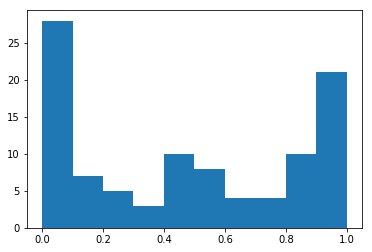

In [55]:
%%time
length = 10000000
xknot = np.random.rand(100)
out = np.empty(xknot.size)

for i,x_0 in enumerate(xknot):
    out[i] = problem1_2(x_0, length = length)
    
plt.hist(out)

## Exercise 1.3. {-}

In the lecture it was claimed that, if $\left(\mathbb{X},g\right)$ is a dynamical system, $g$ continuous at $\hat{x}\in\mathbb{X}$, and for some $x\in\mathbb{X}$, $g^{t}(x)\to\hat{x}$, then $\hat{x}$ is a steady state of $\left(\mathbb{X},g\right)$. Prove this.

#### Solution. {-}
Let $y\in C = \left\{ x \in \mathbb{X} \mid \lim_{t\to\infty} g^t (x) = \hat{x} \right\}$. Since $g$ is continuous at $\hat{x}$, and $\lim_{t\to\infty} g^{t-1} (y) = \hat{x}$, we have that
$$
\begin{eqnarray*}
\hat{x}&=&\lim_{t\to\infty} g^t (x) \\
&=& g\left( \lim_{t\to\infty}g^{t-1}(x)\right) \\
&=&g\left(\hat x\right). 
\end{eqnarray*}
$$
$\blacksquare$

## Exercise 2.1. {-}

In [56]:
class problem2_1:
    
    def __init__(self, X, h=None):
        
        self.X = X
        self.n = X.size
        
        if not h:
            self.h = self.silverman()
        else:
            self.h = h
            
    def silverman(self):
        return 1.06 * (self.n ** (-1/5)) * np.sqrt(np.var(self.X))
    
    def f(self, x):
        K = norm.pdf
        summand = K( (x - self.X) / self.h )
        return (1/(self.h*self.n)) * summand.sum()
    
    def estimate(self, grid=np.linspace(0,1,1000)):
        estimation = np.empty_like(grid)
        
        for j,k in enumerate(grid):
            estimation[j] = self.f(k)
            
        return estimation

In [57]:
n, grid = 1000, np.linspace(0,1,1000)


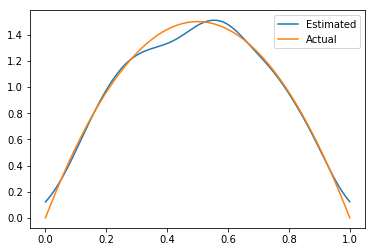

In [58]:
α2β2 = np.random.beta(2,2,size=(n,1))
estimator_α2β2 = problem2_1(X = α2β2)
estimate_α2β2 = estimator_α2β2.estimate(grid=grid)
plt.plot(grid, estimate_α2β2, label = "Estimated")
plt.plot(grid, beta.pdf(grid,2,2),label = "Actual")
plt.legend()
plt.show()

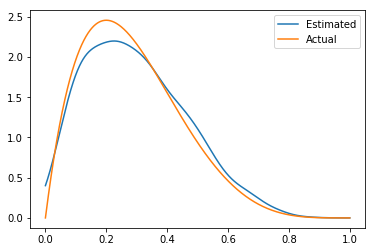

In [59]:
α2β5 = np.random.beta(2,5,size=(n,1))
estimator_α2β5 = problem2_1(X=α2β5)
estimate_α2β5 = estimator_α2β5.estimate(grid=grid)
plt.plot(grid, estimate_α2β5, label="Estimated")
plt.plot(grid, beta.pdf(grid,2,5), label= "Actual")
plt.legend()
plt.show()

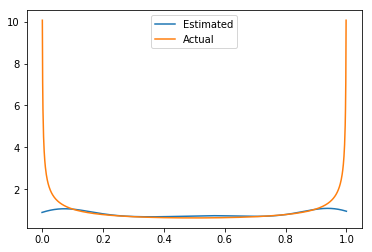

In [60]:
α05β05 = np.random.beta(0.5,0.5,size=(n,1))
estimator_α05β05 = problem2_1(X=α05β05)
estimate_α05β05 = estimator_α05β05.estimate(grid=grid)
plt.plot(grid, estimate_α05β05, label="Estimated")
plt.plot(grid, beta.pdf(grid,0.5,0.5), label="Actual")
plt.legend()
plt.show()

## Exercise 2.2. {-}

In [61]:
ρ, b, σ, μ, s = 0.9, 0.0, 0.1, -3, 0.2

In [62]:
def problem2_2(x, ρ=ρ, b=b, σ=σ):
    ξ = np.random.standard_normal()
    return (ρ * x) + b + (σ * ξ)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.


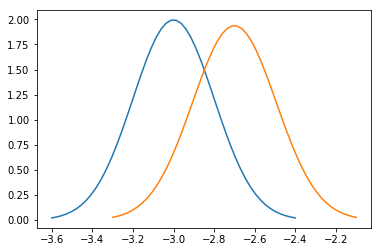

In [66]:
grid = np.linspace(0,1,1000)
ψ = norm.pdf(grid, loc=μ, scale=s**2)
plt.plot(np.linspace(μ- 3*s, μ+3*s), matplotlib.mlab.normpdf(np.linspace(μ- 3*s, μ+3*s), μ, s))
plt.plot(np.linspace(ρ*μ + b - 3*s, ρ*μ + b + 3*s), matplotlib.mlab.normpdf(np.linspace(ρ*μ + b - 3*s, ρ*μ + b + 3*s), ρ*μ + b, np.sqrt((ρ**2)*(s**2) + (σ**2))))

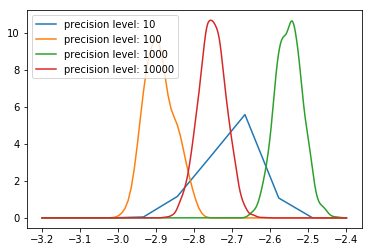

In [67]:
ngrid = [10,100,1000,10000]
for n in ngrid:
    dist = problem2_2(np.random.normal(μ, s**2, n))
    estimator = problem2_1(dist)
    
    grid = np.linspace(-3.2,-2.4,n)
    density = estimator.estimate(grid=grid)
    plt.plot(grid,density,label="precision level: {}".format(n))
    
plt.legend()

## Exercise 2.3. {-}

In the lecture it was claimed that, for $n\times n$ matrix $A$, we have 
$$
r(A)<1\implies A^{k}\to0
$$
where convergence is in terms of the spectral norm.

Prove this using Gelfand's formula.

#### Solution. {-}
Let $A\in M_{n\times n}$, and let $A$ have spectral radius $r(A)<1$. Consider arbitrary $\varepsilon$ such that $0<\varepsilon<1-r(A)$. 

By Gelfand's formula, $\exists K(\varepsilon)\in\mathbb{N}$ such that $\forall k\geq K(\varepsilon)$, we have that
$$
\begin{eqnarray*}
(r(A)-\varepsilon)^{k} &<& \Vert A^{k} \Vert \\
&<& (r(A)+\varepsilon)^{k}.
\end{eqnarray*}
$$
But $\Vert A^{k} \Vert \geq 0$, so
$$
\begin{eqnarray*}
0 &<& \Vert A^{k} \Vert \\
&<& (r(A)+\varepsilon)^{k}.
\end{eqnarray*}
$$
Since $\varepsilon$ arbitrary, it follows that $\lim_{k\to\infty} (r(A)+\varepsilon)^{k}=0$. Thus, $\lim_{k\to\infty} \Vert A^k \Vert = 0$. 

$\blacksquare$